In [1]:
%load_ext autoreload
%autoreload 2


# System imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse

# Libs and helpers
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.envelopes as envelopes

2022-06-02 11:02:03.856604: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-02 11:02:03.856632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_dynamics(exp, psi_init, seq):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

In [3]:
# One fixed frequency qubit coupled to a frequency tunable qubit

qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6

q1 = chip.Qubit(
    name="Q1",
    freq=Qty(value=freq_q1, min_val=4.995e9, max_val=5.005e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q1, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
)

freq_q2 = 5.6e9
anhar_q2 = -240e6
phi_0 = Qty(1)
phi = Qty(0.3)
d = Qty(0.5)

q2 = chip.Transmon(
    name="Q2",
    freq=Qty(value=freq_q2, min_val=5.595e9, max_val=5.605e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q2, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    d=d,
    phi=phi,
    phi_0=phi_0,
)


coupling_strength = 50e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_YY
)

2022-06-02 11:02:06.132799: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-02 11:02:06.133018: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-02 11:02:06.133036: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-02 11:02:06.133059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (max-laptop): /proc/driver/nvidia/version does not exist
2022-06-02 11:02:06.133375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appr

In [4]:
# Frequency drive on qubit 2
Z_drive2 = chip.Drive(
    name="Zd2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.z_drive
)

# Drive on coupling
Coup_drive = chip.Coupling_Drive(
    name="Cd",
    connected=["Q1", "Q2"],
    hamiltonian_func=hamiltonians.int_YY
)

In [5]:
model = Mdl(
    [q1, q2], # Individual, self-contained components
    [Z_drive2, q1q2, Coup_drive],  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(True)

In [11]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG

# Standard devices
lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')
dig_to_an = devices.DigitalToAnalog(name="dac", resolution=sim_res)


# Frequency tuning of seconf qubit
flux_tuning = devices.FluxTuning(name="flux_tuning", phi_0=phi_0, phi=phi, d=d, omega_0=Qty(freq_q2, unit='Hz 2pi'), anhar=Qty(anhar_q2, unit='Hz 2pi'))

# Coupling tuning to capture dependence of coupling on the frequency of the coupled elements
coup_tuning_1 = devices.CouplingTuning(name="coup_tuning_one",
                                            two_inputs=False,
                                            w_2=Qty(freq_q1, unit='Hz 2pi'), 
                                            w_1=Qty(q2.get_freq()/(2*np.pi), unit='Hz 2pi'), 
                                            g0=Qty(coupling_strength, unit='Hz 2pi'),
                                            )


generator = Gnr(
        devices={
            "LO": lo,
            "AWG": awg,
            "DigitalToAnalog": dig_to_an,
            "Mixer": mixer,
            "flux_tuning": flux_tuning,
            "coup_tuning_one": coup_tuning_1
        },
        chains={
            # Line for frequency modulation
            "Zd2": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "flux_tuning": ["Mixer"],
            },
            # Line for coupling modulation. Input for coupling tuning is the frequency tuning of the connected elements
            "Cd": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "flux_tuning": ["Mixer"],
                "coup_tuning_one": ["flux_tuning"]
            }
        }
    )

/home/max/anaconda3/envs/c3-dev/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


In [12]:
# Create a gate with frequency dependent coupling ("gate") and without frequency dependent coupling ("gate_no")
t_final_2Q = 200e-9

gauss_params= {
    'amp': Qty(value=0.1, min_val=0.02, max_val=0.6, unit="V"),
    't_final': Qty(value=t_final_2Q, min_val=0.5 * t_final_2Q, max_val=1.5 * t_final_2Q, unit="s"),
    'sigma': Qty(value=t_final_2Q / 4, min_val=t_final_2Q / 8, max_val=t_final_2Q / 2, unit="s"),
}

gauss_env = pulse.EnvelopeDrag(
    name="gauss1",
    desc="Gaussian envelope on drive 1",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm
)

lo_freq = 322.80e6
carr = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq, min_val=0.9 * lo_freq, max_val=1.1 * lo_freq, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

gate = gates.Instruction(
    name="gate", targets=[0, 1], t_start=0.0, t_end=t_final_2Q, channels=["Zd2", "Cd"],
)
gate.add_component(gauss_env, "Zd2")
gate.add_component(carr, "Zd2")

gate.add_component(gauss_env, "Cd")
gate.add_component(carr, "Cd")


gate_no = gates.Instruction(
    name="gate_no", targets=[0, 1], t_start=0.0, t_end=t_final_2Q, channels=["Zd2"],
)
gate_no.add_component(gauss_env, "Zd2")
gate_no.add_component(carr, "Zd2")



In [13]:
parameter_map = PMap(instructions=[gate, gate_no], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

In [14]:
psi_init = [[0] * 9]
psi_init[0][1] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

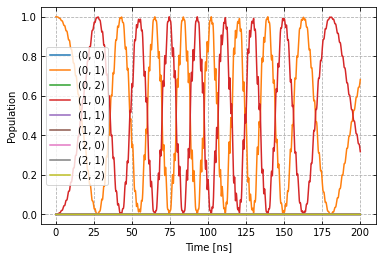

In [15]:
# Dynamics with frequency dependent coupling
sequence = [gate.get_key()]
plot_dynamics(exp, init_state, sequence)

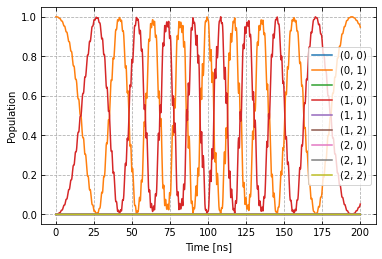

In [16]:
# Different dynamics without frequency dependent coupling
sequence = [gate_no.get_key()]
plot_dynamics(exp, init_state, sequence)

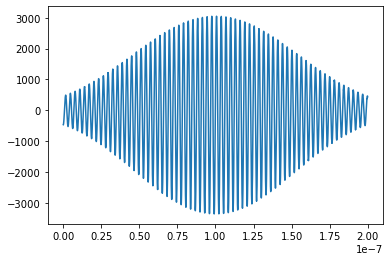

In [19]:
# Frequency modulation
signals = generator.generate_signals(gate)
end = -1
plt.plot(signals["Zd2"]["ts"][:end], signals["Zd2"]["values"][:end]/1e6)

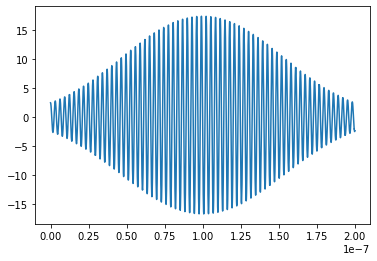

In [20]:
# Coupling modulation
signals = generator.generate_signals(gate)
end=-1
plt.plot(signals["Cd"]["ts"][:end], signals["Cd"]["values"][:end]/1e6)